In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 自定義檢定函數 ==========

def f_test_variances(x1, x2, sides, alpha):
    a1 = np.array(x1)
    a2 = np.array(x2)
    result = np.full((7, 2), None, dtype=float)

    result[0] = [np.mean(a1), np.mean(a2)]
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]
    result[2] = [a1.size, a2.size]
    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    if sides > 1:
        result[5] = [stats.f.isf(alpha / 2, dfn, dfd), stats.f.ppf(alpha / 2, dfn, dfd)]
    else:
        result[5] = [stats.f.isf(alpha, dfn, dfd), stats.f.ppf(alpha, dfn, dfd)]

    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    return pd.DataFrame(result, index=labels)


def t_test_two_means_unequal_variance(x1, x2, sides, alpha, H0_diff):
    a1 = np.array(x1)
    a2 = np.array(x2)
    result = np.full((8, 2), None, dtype=float)

    mean1, mean2 = np.mean(a1), np.mean(a2)
    var1, var2 = np.var(a1, ddof=1), np.var(a2, ddof=1)
    n1, n2 = a1.size, a2.size

    result[0] = [mean1, mean2]
    result[1] = [var1, var2]
    result[2] = [n1, n2]

    mean_diff = mean1 - mean2
    diff_var = var1 / n1 + var2 / n2
    result[3, 0] = H0_diff

    numerator = diff_var ** 2
    denominator = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
    df = numerator / denominator
    result[4, 0] = df

    t_stat = (mean_diff - H0_diff) / np.sqrt(diff_var)
    result[5, 0] = t_stat

    if sides > 1:
        result[6] = [stats.t.isf(alpha / 2, df), stats.t.ppf(alpha / 2, df)]
    else:
        result[6] = [stats.t.isf(alpha, df), stats.t.ppf(alpha, df)]

    if t_stat > 0:
        p_value = 1 - stats.t.cdf(t_stat, df)
    else:
        p_value = stats.t.cdf(t_stat, df)
    if sides > 1:
        p_value *= 2
    result[7, 0] = p_value

    labels = [
        'Mean', 'Variance', 'Size', 'H0 Diff',
        'Degrees of Freedom', 't-statistic', 't-critical', 'p-value'
    ]
    return pd.DataFrame(result, index=labels)


def run_t_test_summary(df, col1, col2, usevar='pooled', alpha=0.05):
    group1 = sms.DescrStatsW(df[col1].values)
    group2 = sms.DescrStatsW(df[col2].values)
    t_test = sms.CompareMeans(group1, group2)
    return t_test.summary(usevar=usevar, alpha=alpha)

sequel
0.0    14192
1.0      533
Name: count, dtype: int64


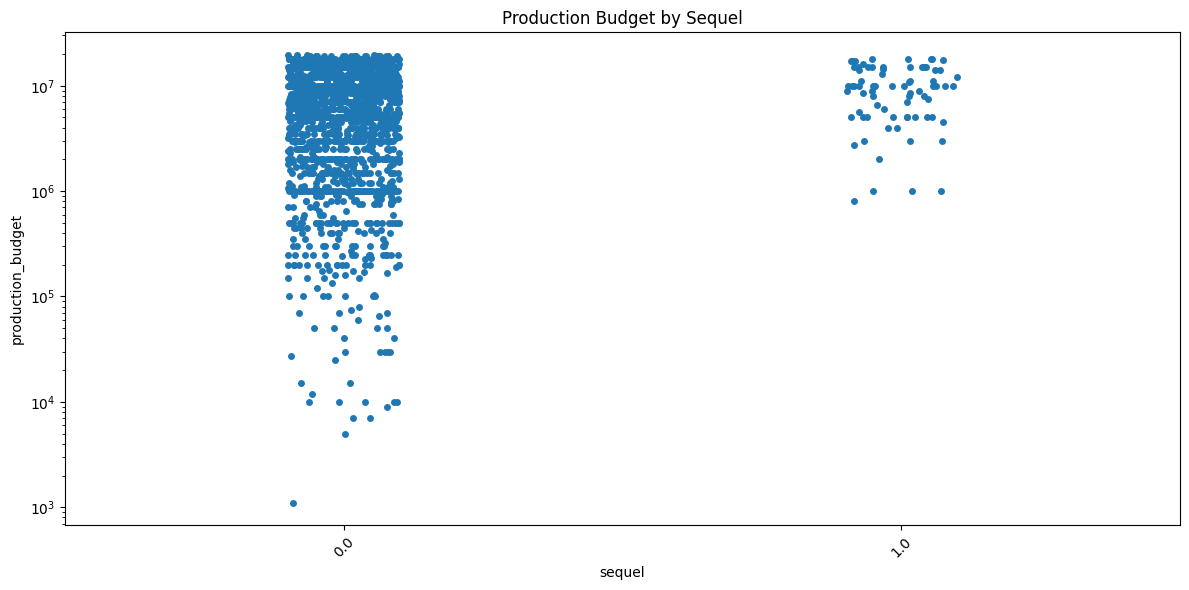

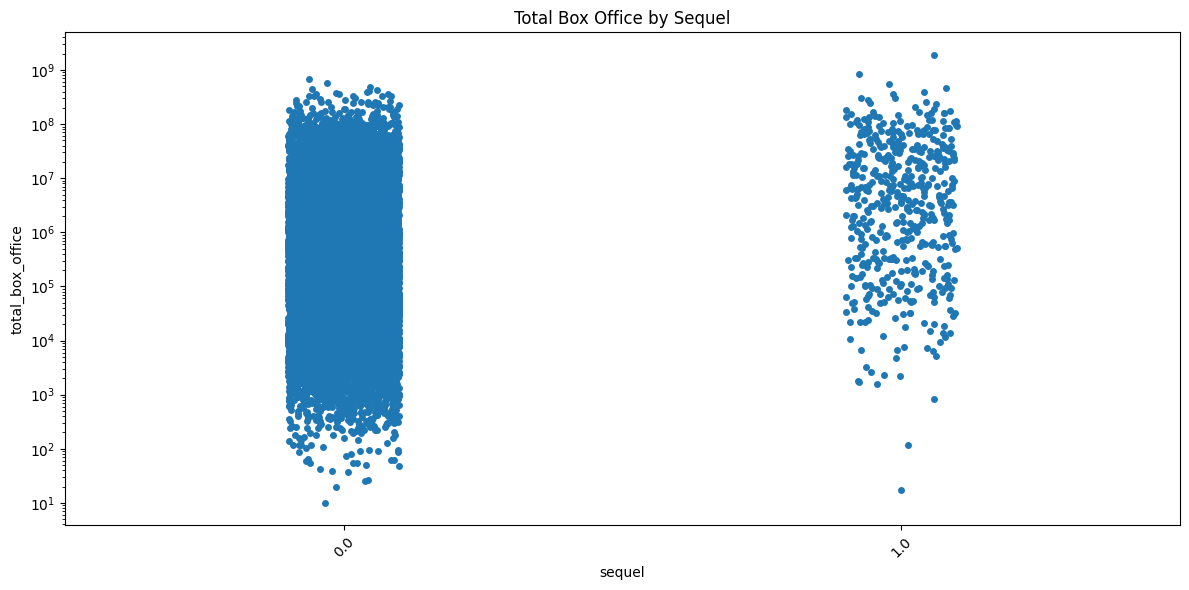

In [3]:
# ========== 開始作檢定==========

df = pd.read_csv('movie_summary.csv')

# filter data
filtered_df = df[
    (df['production_year'] > 2000) &
    (df['production_budget'] < 20000000) &
    df['sequel'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()
# 計算總票房
filtered_df['total_box_office'] = (
    filtered_df['domestic_box_office'] + filtered_df['international_box_office']
)

print(filtered_df['sequel'].value_counts())

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='sequel', y='production_budget', jitter=True)
plt.yscale('log')
plt.title("Production Budget by Sequel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=filtered_df, x='sequel', y='total_box_office', jitter=True)
plt.yscale('log')
plt.title("Total Box Office by Sequel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# 分組
x0 = filtered_df[filtered_df['sequel'] == 0]['total_box_office']
x1 = filtered_df[filtered_df['sequel'] == 1]['total_box_office']

# 顯示基本描述統計
print("Sequel = 0:")
print(x0.describe())
print("\nSequel = 1:")
print(x1.describe())

# === 1. F 檢定：變異數是否相等 ===
print("\n=== F Test: Equality of Variances ===")
f_result = f_test_variances(x0, x1, sides=2, alpha=0.05)
print(f_result.round(4))

# === 2. t 檢定（Welch's）：平均數是否相等 ===
print("\n=== Welch's t-test: Equality of Means ===")
t_result = t_test_two_means_unequal_variance(x0, x1, sides=2, alpha=0.05, H0_diff=0)
print(t_result.round(4))

# === 3. t 檢定摘要報告：使用 statsmodels ===
print("\n=== Summary Report using statsmodels ===")
group1 = sms.DescrStatsW(x0.values)
group2 = sms.DescrStatsW(x1.values)
t_test = sms.CompareMeans(group1, group2)
print(t_test.summary(usevar='unequal', alpha=0.05))

Sequel = 0:
count    1.419200e+04
mean     6.227188e+06
std      2.360624e+07
min      0.000000e+00
25%      1.887950e+04
50%      1.742435e+05
75%      2.179795e+06
max      6.928325e+08
Name: total_box_office, dtype: float64

Sequel = 1:
count    5.330000e+02
mean     3.162452e+07
std      1.064358e+08
min      0.000000e+00
25%      1.914080e+05
50%      3.336053e+06
75%      2.531000e+07
max      1.914532e+09
Name: total_box_office, dtype: float64

=== F Test: Equality of Variances ===
                               0             1
Mean                6.227188e+06  3.162452e+07
Std Dev             2.360624e+07  1.064358e+08
Size                1.419200e+04  5.330000e+02
Degrees of Freedom  1.419100e+04  5.320000e+02
F-statistic         4.920000e-02           NaN
F-critical          1.134300e+00  8.878000e-01
p-value             0.000000e+00           NaN

=== Welch's t-test: Equality of Means ===
                               0             1
Mean                6.227188e+06  3.1624

In [5]:
# 指定要分析的 genre
target_genres = ['Romantic', 'Comedy', 'Drama', 'Documentary', 'Horror', 'Thriller/Suspense']
results = []

# 分析每個 genre
for genre in target_genres:
    genre_df = filtered_df[filtered_df['genre'] == genre]
    if genre_df['sequel'].value_counts().min() < 10:
        continue  # 若續集或非續集樣本數過少，跳過此類型

    x0 = genre_df[genre_df['sequel'] == 0]['total_box_office']
    x1 = genre_df[genre_df['sequel'] == 1]['total_box_office']

    # Welch's t-test
    t_stat, p_val = stats.ttest_ind(x0, x1, equal_var=False)

    # 效果量 Cohen's d
    pooled_sd = np.sqrt((np.var(x0, ddof=1) + np.var(x1, ddof=1)) / 2)
    cohen_d = (np.mean(x1) - np.mean(x0)) / pooled_sd

    results.append({
        'Genre': genre,
        'Sequel N': len(x1),
        'Non-Sequel N': len(x0),
        'Sequel Mean': np.mean(x1),
        'Non-Sequel Mean': np.mean(x0),
        'Mean Diff': np.mean(x1) - np.mean(x0),
        'p-value (Welch)': p_val,
        "Cohen's d": cohen_d
    })

results_df = pd.DataFrame(results)
print(results_df)

# CSV
results_df.to_csv('sequel_analysis_results.csv', index=False)
print("\nResults saved to 'sequel_analysis_results.csv'")

               Genre  Sequel N  Non-Sequel N   Sequel Mean  Non-Sequel Mean  \
0           Romantic         0             0           NaN              NaN   
1             Comedy       118          2037  2.330262e+07     9.001958e+06   
2              Drama        51          4787  1.713003e+07     5.466829e+06   
3        Documentary        20          2292  3.093434e+06     1.212734e+06   
4             Horror        84           633  4.043922e+07     1.209501e+07   
5  Thriller/Suspense        23          1081  1.955766e+07     7.077712e+06   

      Mean Diff  p-value (Welch)  Cohen's d  
0           NaN              NaN        NaN  
1  1.430066e+07         0.001175   0.372896  
2  1.166320e+07         0.014154   0.432225  
3  1.880700e+06         0.489049   0.188100  
4  2.834421e+07         0.000211   0.529630  
5  1.247995e+07         0.078587   0.462104  

Results saved to 'sequel_analysis_results.csv'


C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


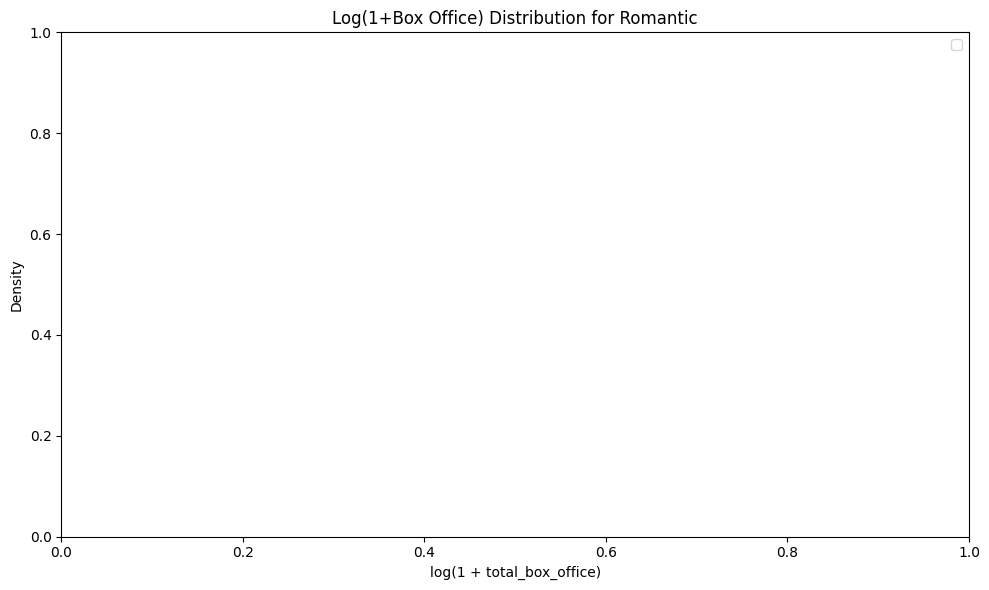

C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')


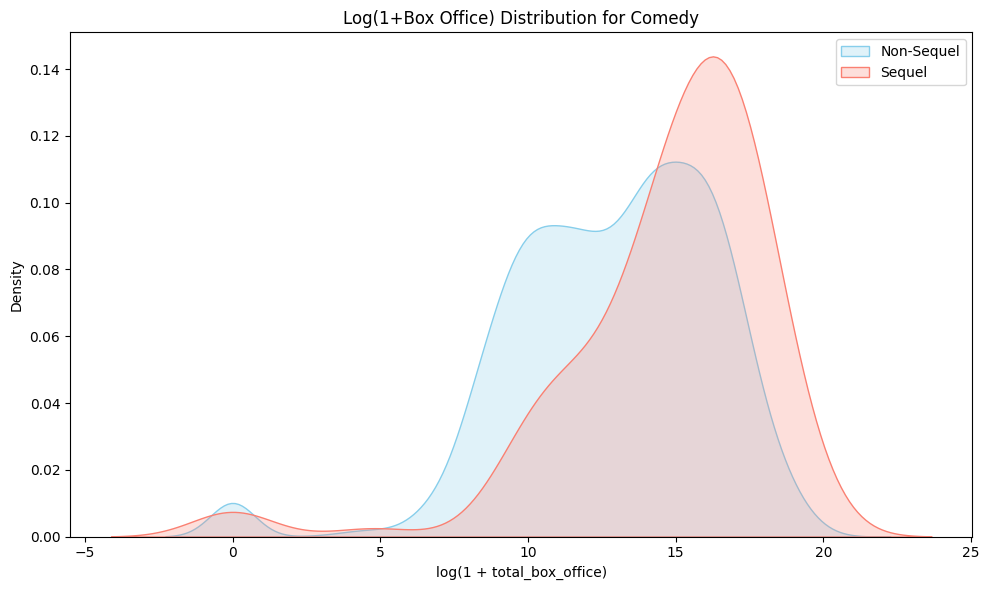

C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')


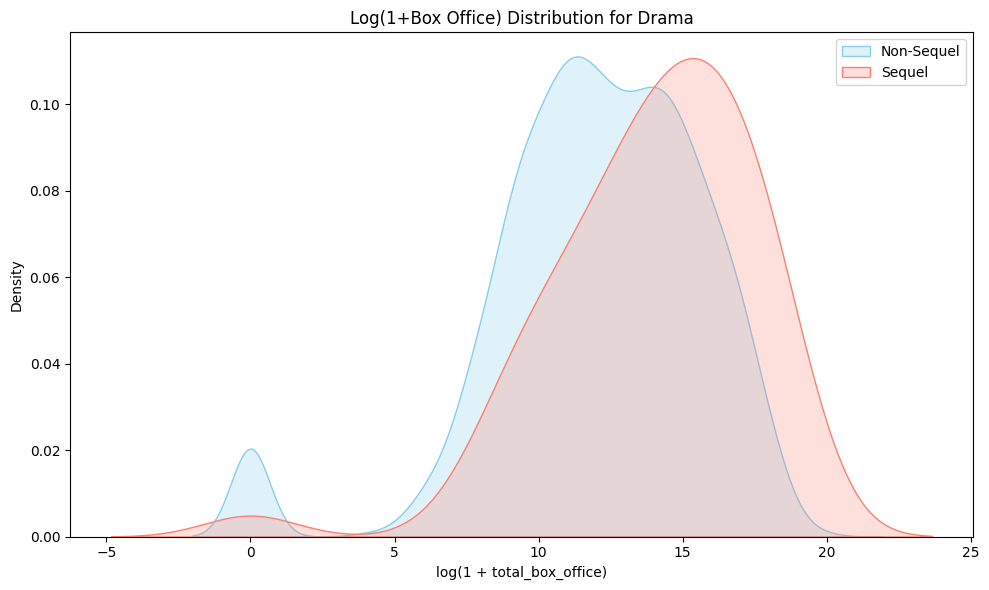

C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')


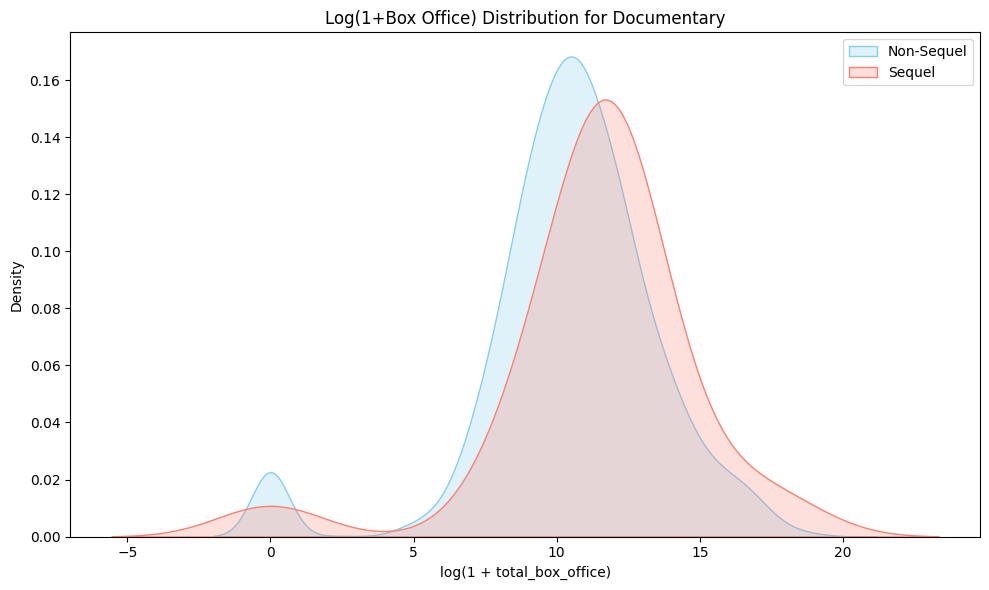

C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')


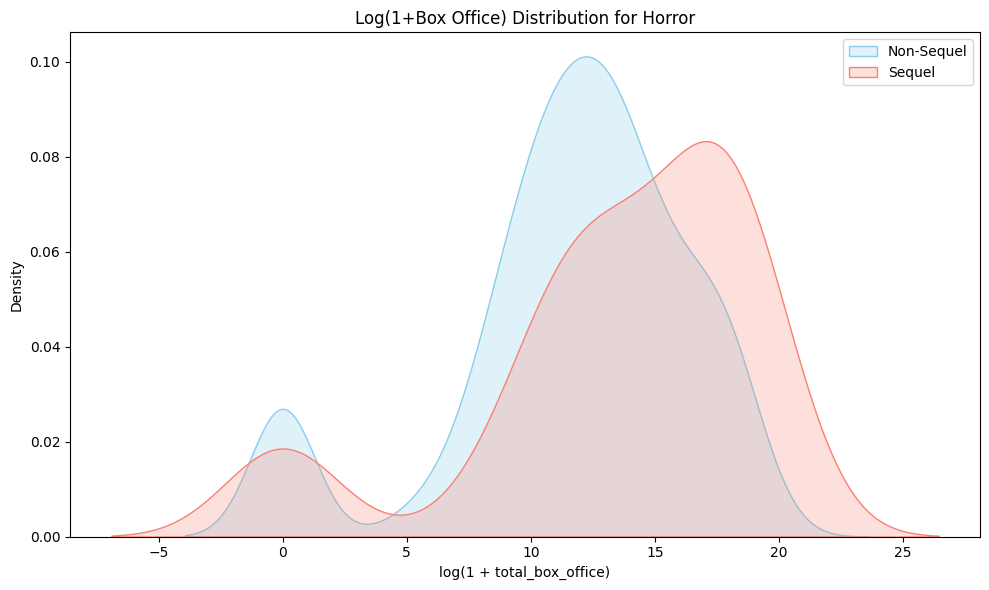

C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
C:\Users\chenj\AppData\Local\Temp\ipykernel_25856\841913467.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')


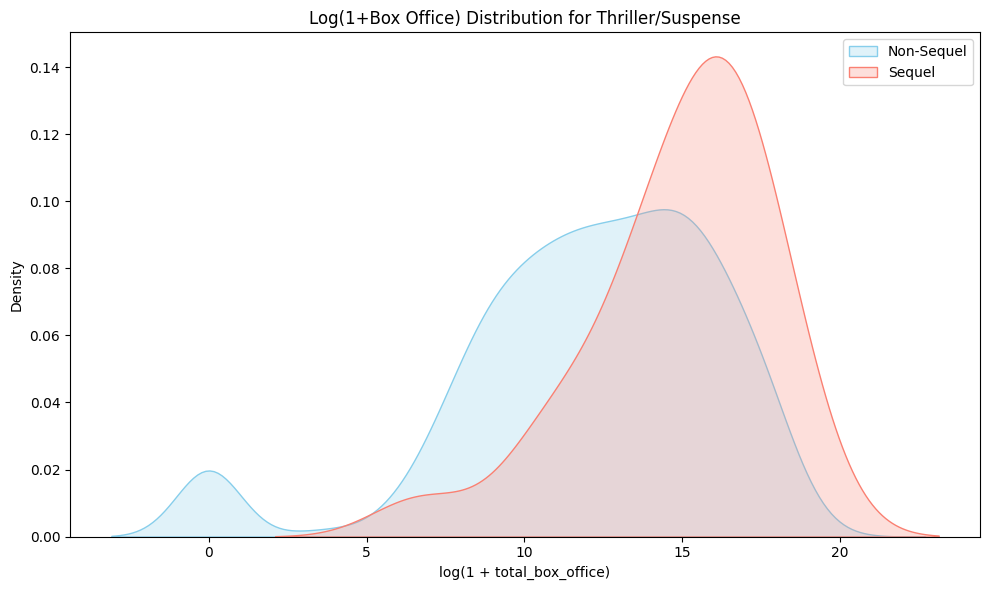

In [8]:
# Plotting overlaid KDEs for each genre
for genre in target_genres:
    genre_df = filtered_df[filtered_df['genre'] == genre]
    if genre_df['sequel'].value_counts().min() < 10:
        continue  # Skip if not enough data

    x0 = np.log1p(genre_df[genre_df['sequel'] == 0]['total_box_office'])
    x1 = np.log1p(genre_df[genre_df['sequel'] == 1]['total_box_office'])

    plt.figure(figsize=(10, 6))
    sns.kdeplot(x0, label='Non-Sequel', shade=True, color='skyblue')
    sns.kdeplot(x1, label='Sequel', shade=True, color='salmon')
    plt.title(f'Log(1+Box Office) Distribution for {genre}')
    plt.xlabel('log(1 + total_box_office)')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()
